In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download stock data
df = yf.download('AAPL', start='2023-01-01', end='2025-1-1')
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-01-03,123.470612,129.226052,122.582119,128.613985,112117500
2023-01-04,124.744118,127.014709,123.480487,125.267339,89113600
2023-01-05,123.421257,126.136090,123.164587,125.504275,80962700
2023-01-06,127.962433,128.623863,123.292924,124.398604,87754700
2023-01-09,128.485626,131.703947,128.228957,128.801541,70790800
...,...,...,...,...,...
2024-12-24,257.578674,257.588630,254.675658,254.875189,23234700
2024-12-26,258.396667,259.474086,257.010028,257.568678,27237100


In [3]:
#keep both 'close' and 'volume'
df = df[['Close','Volume']].rename(columns={"Close": "y"})
df['ds'] = df.index
df.reset_index(drop=True, inplace=True)
df

Price,y,Volume,ds
Ticker,AAPL,AAPL,
0,123.470612,112117500,2023-01-03
1,124.744118,89113600,2023-01-04
2,123.421257,80962700,2023-01-05
3,127.962433,87754700,2023-01-06
4,128.485626,70790800,2023-01-09
...,...,...,...
497,257.578674,23234700,2024-12-24
498,258.396667,27237100,2024-12-26
499,254.974930,42355300,2024-12-27


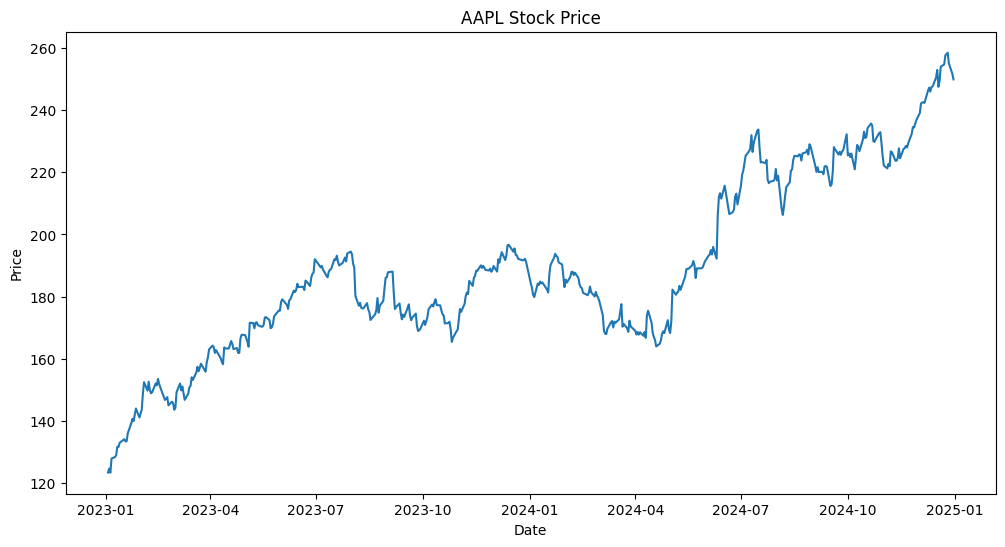

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'])
plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [5]:
 # Check for missing values
df.isnull().sum()

,,0
Price,Ticker,
y,AAPL,0
Volume,AAPL,0
ds,,0


In [6]:
# Check stationarity (ADF Test)
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['y'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values:')
for key, value in adf_test[4].items():
    print(f'\t%s:%.3f '%(key,value))

ADF Statistic: -1.1947519168114888
p-value: 0.6758492204521029
Critical Values:
	1%:-3.443 
	5%:-2.867 
	10%:-2.570 


In [7]:
# using differencing as p value is not >= 0.5
df['y_diff1'] = df['y'].diff()

In [8]:
#checking stationarity again
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['y_diff1'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -20.87212325768548
p-value: 0.0


In [9]:
#train - test split
train = df[:-365]
test = df[-365:]

In [10]:
def sarima_grid_search(y, pdq, seasonal_pdq, s):
    best_score, best_cfg = float("inf"), None
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(y,
                                order=param,
                                seasonal_order=seasonal_param + (s,),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_score:
                    best_score, best_cfg = results.aic, (param, seasonal_param)
            except:
                continue
    return best_cfg

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q))
best_params = sarima_grid_search(train['y'], pdq, seasonal_pdq, 12)

In [18]:
def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return {"RMSE": rmse, "MAE": mae}

In [28]:
# Train ARIMA (no exogenous variables, no seasonality)
model_arima = ARIMA(train['y'], order=(5, 1, 2)).fit()

# Forecast 365 days into the future
pred_arima = model_arima.forecast(steps=365)

# Evaluate predictions against the test set
result_arima = evaluate(test['y'], pred_arima)
print("ARIMA:", result_arima)

ARIMA: {'RMSE': np.float64(25.833772024309628), 'MAE': 20.635036913936208}


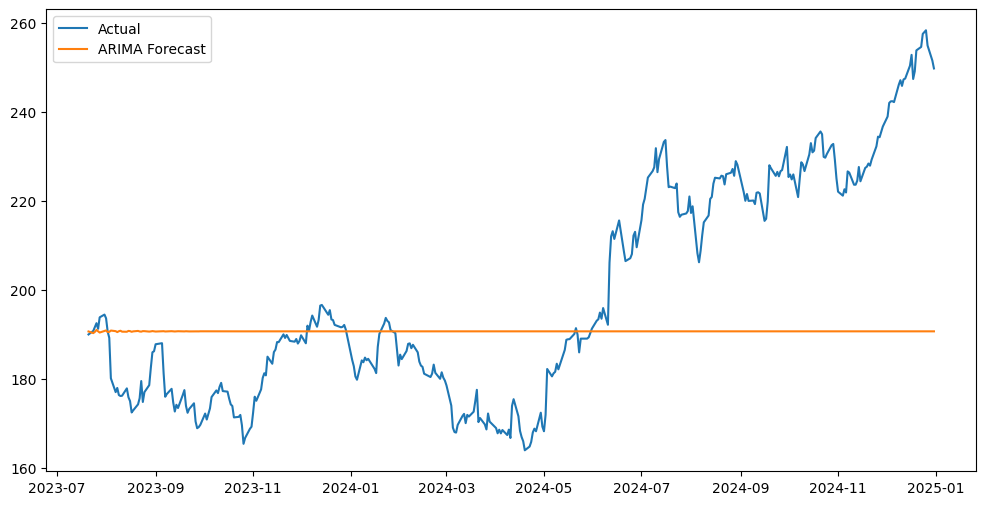

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], pred_arima, label='ARIMA Forecast')
plt.legend()
plt.show()

In [29]:
# Train SARIMA (seasonal, no exogenous)
model_sarima = SARIMAX(train['y'],
                       order=(2, 1, 2),
                       seasonal_order=(1, 1, 1, 12)).fit()

# Forecast 365 days into the future
pred_sarima = model_sarima.forecast(steps=365)

# Evaluate predictions against the test set
result_sarima = evaluate(test['y'], pred_sarima)
print("SARIMA:", result_sarima)

SARIMA: {'RMSE': np.float64(89.73427247951909), 'MAE': 82.88900675486427}


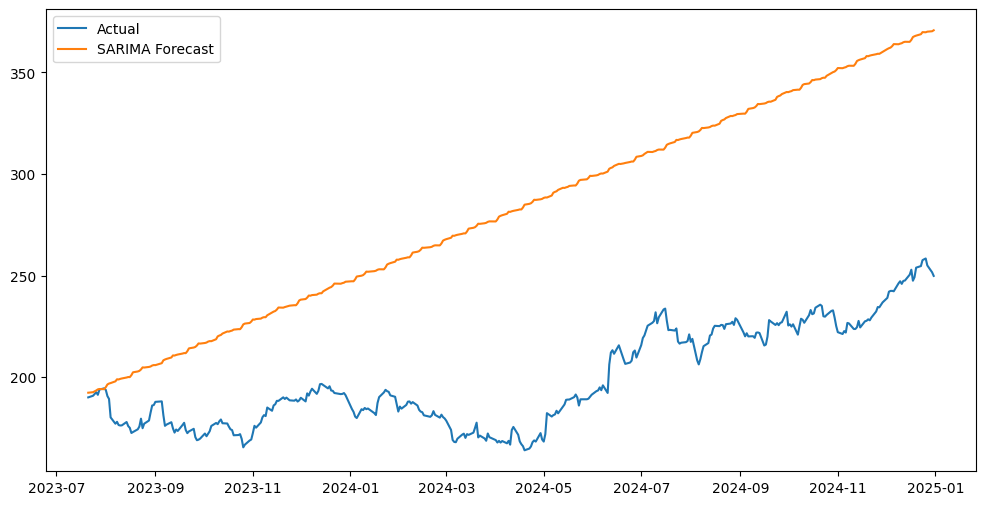

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], pred_sarima, label='SARIMA Forecast')
plt.legend()
plt.show()

In [30]:
# Train ARIMAX (ARIMA with exogenous variable, no seasonality)
model_arimax = SARIMAX(train['y'],
                       exog=train[['Volume']],
                       order=(3, 1, 2)).fit()

# Forecast 365 days using exogenous test data
pred_arimax = model_arimax.forecast(steps=365, exog=test[['Volume']])

# Evaluate predictions
result_arimax = evaluate(test['y'], pred_arimax)
print("ARIMAX:", result_arimax)

ARIMAX: {'RMSE': np.float64(25.855240593342764), 'MAE': 20.726318180943537}


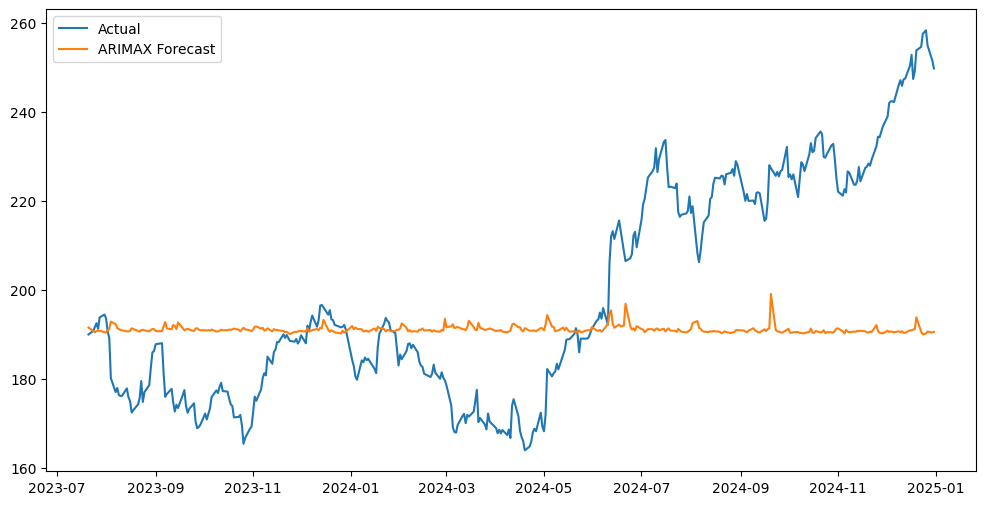

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], pred_arimax, label='ARIMAX Forecast')
plt.legend()
plt.show()

In [27]:
# Train SARIMAX
model_sarimax = SARIMAX(train['y'], exog=train[['Volume']],
                        order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()

# Forecast with SARIMAX using exogenous variable
pred_sarimax = model_sarimax.forecast(steps=365, exog=test[['Volume']])

# Evaluate
result_sarimax = evaluate(test['y'], pred_sarimax)
print("SARIMAX:", result_sarimax)

SARIMAX: {'RMSE': np.float64(66.46588805328527), 'MAE': 61.93778465739829}


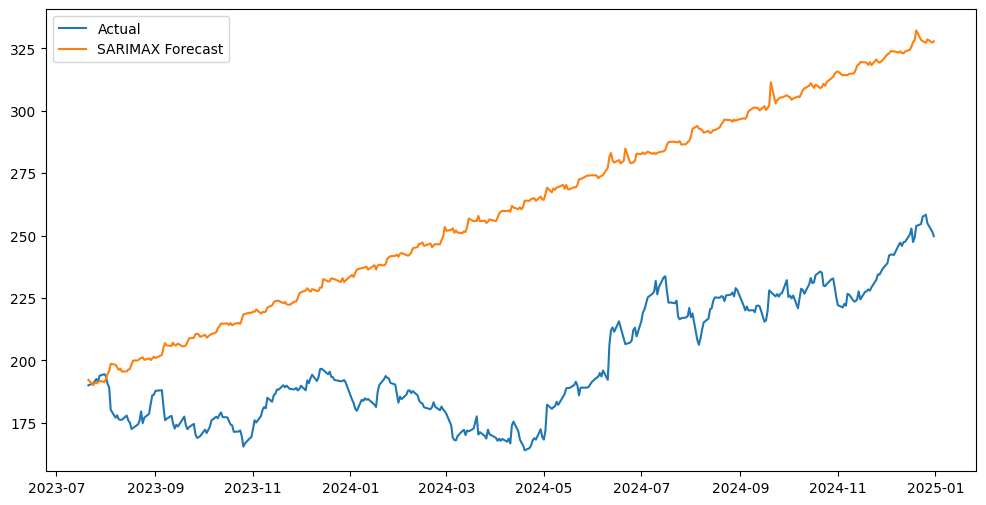

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], pred_sarimax, label='SARIMAX Forecast')
plt.legend()
plt.show()

In [35]:
results = []

In [37]:
# ARIMA
result_arima = evaluate(test['y'], pred_arima)
results.append({'Model': 'ARIMA', **result_arima})

# SARIMA
result_sarima = evaluate(test['y'], pred_sarima)
results.append({'Model': 'SARIMA', **result_sarima})

# ARIMAX
result_arimax = evaluate(test['y'], pred_arimax)
results.append({'Model': 'ARIMAX', **result_arimax})

# SARIMAX
result_sarimax = evaluate(test['y'], pred_sarimax)
results.append({'Model': 'SARIMAX', **result_sarimax})



In [38]:
df_results = pd.DataFrame(results)
print(df_results)

     Model       RMSE        MAE
0    ARIMA  25.833772  20.635037
1   SARIMA  89.734272  82.889007
2   ARIMAX  25.855241  20.726318
3  SARIMAX  66.465888  61.937785
4    ARIMA  25.833772  20.635037
5   SARIMA  89.734272  82.889007
6   ARIMAX  25.855241  20.726318
7  SARIMAX  66.465888  61.937785
